# CFAR+COGA pre-imputation and phenotype processing
**Author:** Jesse Marks <br>
**GitHub:** [133](https://github.com/RTIInternational/bioinformatics/issues/133)

This notebook documents the procedures for the pre-imputation genotype data processing of [COGA](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?id=phs001208) and [CFAR](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?id=phs001788) necessary for the submission to the [Michigan Imputation Server (MIS)](https://imputationserver.sph.umich.edu/start.html). The phenotype files are also processed.

The starting point (input data) for this pipeline is after the quality control (QC) of the observed genotype data. The QC genotype data should be oriented on the GRGh37 plus strand. When multiple data sets are to be merged for imputation, the intersection set of variants will be used for imputation; this is based on the finding from [Johnson et al.](https://link.springer.com/article/10.1007/s00439-013-1266-7). 

**Software and tools** <br>
The software and tools used for processing these data are:
* [Michigan Imputation Server](https://imputationserver.sph.umich.edu/index.html) (MIS)
* [Amazon Web Services (AWS) - Cloud Computing Services](https://aws.amazon.com/)
    * Linux AMI
* [PLINK v1.90 beta 4.10](https://www.cog-genomics.org/plink/)
* [bgzip](http://www.htslib.org/doc/tabix.html)
* [BCF Tools](http://www.htslib.org/doc/bcftools.html)
* Windows 10 with [Cygwin](https://cygwin.com/) installed
* GNU bash version 4.2.46

**Pre-Imputation SNP Summary Stats**
EUR

| Data Set  | Initial | Post-QC | Post Imputation-Filtering | Intersection     |
|-----------|---------|---------|---------------------------|------------------|
| CFAR      | 569,016 | 496,461 |                           |                  |
| COGA      | 568,167 | 523,315 |                           |                  |

## Create Directory Stucture & Download Data
The following section needs to be modified each time to reflect:
* where the genotype data (post-QC) are stored
* where the base directory for the pre-imputation data processing will be
* the study or studies involved
* the ancesty group(s) involved
* the data to be processed (all_chr or chr23)

In [ ]:
# parameters 
base_dir=/shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing # DO NOT end in forward slash
ancestry_list="eur" # space delimited Ex. "eur afr amr"
study_list="cfar coga" # space delimited 
#base_name="chr_all" # chr_all chr23 

# create directory structure
mkdir -p ${base_dir}/{intersect,1000g,impute_prep}
for study in ${study_list};do
    mkdir -p ${base_dir}/${study}/strand_check
    for ancestry in ${ancestry_list};do
        mkdir -p ${base_dir}/${study}/genotype/${ancestry}
    done
done


## copy post-qc genotype data to correct directory
## AND REMAME TO CORRECT NAMING SCHEMA <study_ancestry.$extension> 
## also unzip the Plink files
aws s3 sync s3://rti-shared/shared_data/post_qc/cfar/genotype/array/observed/0001/eur/ $base_dir/cfar/genotype/eur/
aws s3 sync s3://rti-shared/shared_data/post_qc/coga/genotype/array/observed/0001/eur/ $base_dir/coga/genotype/eur/
gunzip $base_dir/{cfar,coga}/genotype/eur/*

## GRCh37 strand and allele discordance check
### MAF for study data (all chromosomes)

In [ ]:
# Write out the MAF report
for study in ${study_list}; do
    for ancestry in ${ancestry_list}; do
        docker run -v "${base_dir}/$study/:/data/" rticode/plink:1.9 plink \
            --bfile /data/genotype/$ancestry/${study} \
            --freq \
            --out /data/strand_check/${ancestry}
    done
done


# Get list of variants from all studies
studies=($study_list)  #studies=(uhs1 uhs2 uhs3_v1-2 uhs3_v1-3 uhs4) # array of study names
num=${#studies[@]}

## Get intersection set
for ancestry in ${ancestry_list};do
    bim_files=()
    for (( i=0; i<${num}; i++ ));do
        bim_files+=(${base_dir}/${studies[$i]}/genotype/$ancestry/*bim)
    done
    
    echo -e "\nCalculating intersection between $ancestry: ${study_list}...\n"
    cat ${bim_files[@]}| cut -f2 | sort |  uniq -c | awk -v num=$num '$1 == num {print $2}' \
        > ${base_dir}/intersect/${ancestry}_variant_intersection.txt
    wc -l ${base_dir}/intersect/${ancestry}_variant_intersection.txt
done 

```
469451 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/intersect/eur_variant_intersection.txt
```

### MAF for 1000G
The current setup requires the 1000G MAF for autosomes and chrX to be processed separately. This pipeline is also currently set up to handle EUR and AFR populations. 
#### Autosomes
Get 1000G MAF for chromosomes 1&ndash;22 (autosomes).

In [ ]:
# Calculate autosome MAFs for 1000G populations
for ancestry in ${ancestry_list};do

    if [ $ancestry == "eur" ]; then
        pop="EUR"
    elif [ $ancestry == "amr" ]; then
        pop="AMR"
    else
        pop="afr"
    fi
    
    for chr in {1..22}; do
        /shared/bioinformatics/software/scripts/qsub_job.sh \
            --job_name ${pop}_${chr}_MAF \
            --script_prefix ${base_dir}/1000g/${pop}_chr${chr}.maf \
            --mem 6.8 \
            --nslots 3 \
            --priority 0 \
            --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
                --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.hap.gz\
                --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr${chr}.legend.gz \
                --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
                --chr ${chr} \
                --out ${base_dir}/1000g/${pop}_chr${chr}.maf \
                --extract ${base_dir}/intersect/${ancestry}_variant_intersection.txt \
                --keep_groups ${pop}
    done
done

#### chrX 
Get 1000G MAF for chromosome 23 (chrX).

In [ ]:
chr=23
for ancestry in ${ancestry_list};do

    if [ $ancestry == "eur" ]; then
        pop="EUR"
    elif [ $ancestry == "amr" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi

    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${pop}_23_MAF \
        --script_prefix ${base_dir}/1000g/${pop}_chr${chr}.maf \
        --mem 6.8 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/perl/stats/calculate_maf_from_impute2_hap_file.pl \
            --hap /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.hap.gz\
            --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chrX_NONPAR.legend.gz \
            --sample /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3.sample \
            --chr $chr \
            --out ${base_dir}/1000g/${pop}_chr${chr}.maf \
            --extract ${base_dir}/intersect/${ancestry}_variant_intersection.txt \
            --keep_groups ${pop}
done

### Merge 1000G chromosomes
Only need to perform this if there were multiple chromosomes for which the MAF was calculated.

In [ ]:
# Merge per chr MAFs for each 1000G population
for ancestry in ${ancestry_list};do
    if [ $ancestry == "eur" ]; then
        pop="EUR"
    elif [ $ancestry == "amr" ]; then
        pop="AMR"
    else
        pop="AFR"
    fi

    head -n1 ${base_dir}/1000g/${pop}_chr1.maf > ${base_dir}/1000g/${pop}_chr_all.maf
    for chr in {1..23}; do
            tail -q -n +2 ${base_dir}/1000g/${pop}_chr${chr}.maf >> \
                ${base_dir}/1000g/${pop}_chr_all.maf
    done
done

### Autosome Discordant Check

In [ ]:
# Run discordance checks for each ancestry group
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        if [ $ancestry = "eur" ]; then
            pop="EUR"
        elif [ $ancestry == "amr" ]; then
            pop="AMR"
        else
            pop="AFR"
        fi

       /shared/bioinformatics/software/scripts/qsub_job.sh \
           --job_name ${ancestry}_${study}_crosscheck \
           --script_prefix ${base_dir}/$study/strand_check/${ancestry}_allele_discordance_check \
           --mem 6 \
           --nslots 3 \
           --priority 0 \
           --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
               --study_bim_file ${base_dir}/${study}/genotype/${ancestry}/*bim
               --study_frq_file ${base_dir}/${study}/strand_check/${ancestry}.frq
               --ref_maf_file ${base_dir}/1000g/${pop}_chr_all.maf
               --out_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance"
    done
done

### chrX Discordant Check
Run this cell below if you are only processing chrX.

In [ ]:
#for study in ${study_list}; do
#    for ancestry in ${ancestry_list};do
#        if [ $ancestry = "ea" ]; then
#            pop=EUR
#    elif [ $ancestry == "ha" ]; then
#        pop="AMR"
#        else
#            pop=AFR
#        fi
#
#        # chr23 discordance check
#        /shared/bioinformatics/software/scripts/qsub_job.sh \
#            --job_name ${ancestry}_${study}_crosscheck \
#            --script_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance_check \
#            --mem 6.8 \
#            --nslots 1 \
#            --priority 0 \
#            --program "Rscript /shared/bioinformatics/software/R/check_study_data_against_1000G.R
#                --study_bim_file ${base_dir}/data/${study}/genotype/${ancestry}/*bim
#                --study_frq_file ${base_dir}/${study}/strand_check/${ancestry}_chr23.frq
#                --ref_maf_file ${base_dir}/1000g/${pop}_chr23.maf
#                --out_prefix ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance"
#    done
#done

### Resolving allele discordances
The allele discordances will be resolved by
* Flipping allele discordances that are fixed by flipping
* Removing SNPs with discordant names
* Removing SNPs with discordant positions
* Removing allele discordances that are not resolved by flipping
* Removing alleles with large deviations from the reference population allele frequencies

**Note**: We could flip the SNPs that are in the snps.flip file we create here, however we are going to opt not to this time because we found that for this case flipping did not actually resolve the issue because most likely they were monomorphic variants.

In [ ]:
# Apply filters
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        echo -e "\n===============\nProcessing ${study}_${ancestry}\n"
        echo "Making remove list"
        cat <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.at_cg_snps_freq_diff_gt_0.2 | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_names | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_positions | tail -n +2) \
            <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_polymorphic_in_study_not_fixed_by_strand_flip | tail -n +2) | \
              sort -u > ${base_dir}/${study}/strand_check/${ancestry}_snps.remove

        # Create flip list
        echo "Making flip list"
        comm -23 <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles | tail -n +2 | sort -u) \
                 <(cut -f2,2 ${base_dir}/${study}/strand_check/${ancestry}_allele_discordance.discordant_alleles_not_fixed_by_strand_flip | tail -n +2 | sort -u) \
                 > ${base_dir}/${study}/strand_check/${ancestry}_snps.flip

        # Apply filters
        docker run -v ${base_dir}/$study/:/data/ rticode/plink:1.9 plink \
            --bfile  /data/genotype/${ancestry}/${study} \
            --exclude /data/strand_check/${ancestry}_snps.remove \
            --make-bed \
            --out     /data/${ancestry}_filtered
    done
done

wc -l $base_dir/*/*filtered.bim
wc -l $base_dir/*/strand_check/*remove
wc -l $base_dir/*/strand_check/*snps.flip

```
496308 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/cfar/eur_filtered.bim
523162 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/coga/eur_filtered.bim

153 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/cfar/strand_check/eur_snps.remove
153 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/coga/strand_check/eur_snps.remove
 
0 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/cfar/strand_check/eur_snps.flip
0 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/coga/strand_check/eur_snps.flip
```

### Remove monomorphic variants
Monomorphic variants prevent MIS from accepting the genotype data. In this case, an arbitrarily small MAF is set that is smaller than the lower bound for these data.

In [ ]:
# Apply filters
for study in ${study_list}; do
    for ancestry in ${ancestry_list};do
        docker run -v "${base_dir}/$study/:/data/" rticode/plink:1.9 plink \
            --bfile /data/${ancestry}_filtered \
            --maf 0.000001 \
            --make-bed \
            --out /data/${ancestry}_filtered_mono
    done
done

wc -l $base_dir/*/*mono.bim

```
  472694 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/cfar/eur_filtered_mono.bim
  468900 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/coga/eur_filtered_mono.bim
```

## Snp Intersection
Only perform if merging datasets. 
Note that the intersection sets were created in an earlier step.

In [ ]:
studies=($study_list)  #studies=(UHS1 UHS2 UHS3_v1-2 UHS3_v1-3) # array of study names

# Make new PLINK binary file sets
for ancestry in ${ancestry_list};do
    for study in ${studies[@]}; do
        docker run -v "${base_dir}/:/data/" rticode/plink:1.9 plink \
            --bfile /data/$study/${ancestry}_filtered_mono \
            --extract /data/intersect/${ancestry}_variant_intersection.txt \
            --make-bed \
            --out /data/intersect/${study}_${ancestry}_filtered_snp_intersection
    done
done
    
ww $base_dir/intersect/*section.txt

```
  469451 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/intersect/eur_variant_intersection.txt
```

### Merge test
As a final check to confirm that our data sets are all compatible, a PLINK file set merge is conducted. If any issues persist then an error will be raised. 

Only run this section if merging data.

In [ ]:
for ancestry in $ancestry_list; do
    echo "Creating $ancestry merge-list"
    truncate -s 0 ${base_dir}/intersect/${ancestry}_merge_list.txt
    for study in $study_list; do
        echo /data/${study}_${ancestry}_filtered_snp_intersection >>\
        ${base_dir}/intersect/${ancestry}_merge_list.txt
    done
    
# Merge file sets
    echo -e "\n\n======== ${ancestry} ========\n\n"
    docker run -v "${base_dir}/intersect:/data/" rticode/plink:1.9 plink \
        --merge-list /data/${ancestry}_merge_list.txt \
        --make-bed \
        --out /data/${ancestry}_studies_merged
done

wc -l $base_dir/intersect/*merged*bim

```
456760 /shared/rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/processing/intersect/eur_studies_merged.bim
```

## Imputation preparation for Michigan Imputation Server
Visit the [MIS Getting Started Webpage](https://imputationserver.sph.umich.edu/start.html#!pages/help) for more information about the preparing the data for upload to MIS.

### Remove individuals missing whole chromsome
Remove any individual missing, essentially, an entire chromosome. Then convert the data to VCF format.

#### If NO merging was performed
(i.e. only one study being processed)

In [ ]:
## Split by chr and remove any individuals with missing data for whole chr
#for ancestry in $ancestry_list; do
#    for chr in {1..23}; do
#        docker run -v "${base_dir}/:/data/" rticode/plink:1.9 plink \
#            --bfile /data/$study/${ancestry}_filtered_mono \
#            --chr ${chr} \
#            --mind 0.99 \
#            --make-bed \
#            --out /data/impute_prep/${ancestry}_chr${chr}_for_phasing 
#    done
#done > ${base_dir}/impute_prep/chr_splitting.log 
#
#
### look through log files to determine if any subjects were removed
#for ancestry in $ancestry_list; do
#    grep removed $base_dir/impute_prep/$ancestry*log |
#        perl -lne '/(\d+)(\speople)/;
#             $mycount += $1; 
#             print $mycount if eof'  > $base_dir/impute_prep/$ancestry.removed
#    any_removed=$(cat $base_dir/impute_prep/$ancestry.removed)
#    if [ "$any_removed" == 0 ]; then
#        echo "No $ancestry subjects removed"
#    else
#        echo "Some $ancestry subjects removed"
#    fi
#done

#### If merging was performed

In [ ]:
## Split by chr and remove any individuals with missing data for whole chr
for chr in {1..23}; do 
    for ancestry in $ancestry_list;do
        docker run -v "${base_dir}:/data/" rticode/plink:1.9 plink \
            --bfile /data/intersect/${ancestry}_studies_merged \
            --chr ${chr} \
            --mind 0.99 \
            --make-bed \
            --out /data/impute_prep/${ancestry}_chr${chr}_for_phasing
    done > ${base_dir}/impute_prep/chr_splitting.log 
done


## look through log files to determine if any subjects were removed
for ancestry in $ancestry_list; do
    grep removed $base_dir/impute_prep/$ancestry*log |
        perl -lne '/(\d+)(\speople)/;
             $mycount += $1; 
             print $mycount if eof'  > $base_dir/impute_prep/$ancestry.removed
    any_removed=$(cat $base_dir/impute_prep/$ancestry.removed)
    if [ "$any_removed" == 0 ]; then
        echo "No $ancestry subjects removed"
    else
        echo "Some $ancestry subjects removed"
    fi
done

```
No ea subjects removed
```

### Convert to VCF

In [ ]:
for ancestry in ${ancestry_list}; do
    mkdir -p ${base_dir}/impute_prep/${ancestry}
    for chr in {1..23}; do
        docker run -v "${base_dir}/impute_prep/:/data/" rticode/plink:1.9 plink \
            --bfile /data/${ancestry}_chr${chr}_for_phasing \
            --output-chr M \
            --set-hh-missing \
            --recode vcf bgz \
            --out /data/$ancestry/${ancestry}_chr${chr}_final
    done
done

Transfer the *.vcf.gz files to local machine (per chromosome) and then upload to MIS.

## Upload to Michigan Imputation Server (MIS)
Transfer the `*.vcf` files to local machine (per chromosome) and then upload to MIS.

**Uploading parameters** 
These are the parameters that were selected on MIS:

__Name__: CFAR+COGA_EA 

__Reference Panel__ 1000G Phase 3 v5

__Input Files__ File Upload <br>

* Select Files - select VCF files that were downloaded to local machine from cloud. <br>

__Phasing__: ShapeIT v2.r790 (unphased) 

__Population__: EUR

__Mode__: Quality Control & Imputation

* I will not attempt to re-identify or contact research participants.
* I will report any inadvertent data release, security breach or other data management incident of which I become aware.

## Extra Processing
We 

In [ ]:
docker run -v "${cwd}:/data/" rticode/plink:1.9 plink
    --bfile /data/ea_chr23_for_phasing\
    --output-chr M\
    --set-hh-missing\
    --filter-females\
    --remove /data/remove_file.txt\
    --recode vcf bgz\
    --out /data/both/ea_chr23_final


## Download Imputed Data from MIS
First Download the data form the Michigan Imputation Server by clicking on the link provided in the email they send out to alert you that your data has finished. Here you will find commands for downloading the data.

In [ ]:
ancestry=ea
study=cfar_coga
passW="KlQvLb7Kz9IDvC"
cd /shared/jmarks/hiv/cfar_coga/genotype/imputed/final/$ancestry


# download.file
####################################################################################################
####################################################################################################

# QC-report
curl -sL https://imputationserver.sph.umich.edu/get/1615357/e4f3711a9e8d8de7076c20af8d704113 | bash
# Logs
curl -sL https://imputationserver.sph.umich.edu/get/1615364/b4f0d11325e4f642b5435d167de15c08 | bash
# SNP Statistics
curl -sL https://imputationserver.sph.umich.edu/get/1615363/74bf8093b59774904aadf4e3f9c42f5e | bash
# Imputation Results
curl -sL https://imputationserver.sph.umich.edu/get/1615360/f1d4b31a9f2c3e15f7d3c11c111aadc8 | bash

####################################################################################################
####################################################################################################

# inflate chr results
for file in *zip; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name unzip.$study.$ancestry.$file \
        --script_prefix unzip.imputed.$study.$ancestry.data \
        --mem 3 \
        --nslots 3 \
        --priority 0 \
        --program unzip -P $passW $file 
done 

# we can remove the original imputed data from MIS after we inflate the zip files
rm -rf *zip

# upload to s3
aws s3 sync . s3://rti-hiv/cfar_coga/data/genotype/imputed/$ancestry --quiet &

# Phenotype file construction
## Data wrangling
Create a phenotype table filtered by the subjects available in the genotype data. <br>
variables of interest:

`HIV Status`
* COGA: we will code all as controls since there are no data available for this
* CFAR: (AFFECTION_STATUS; [cases=1](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/variable.cgi?study_id=phs001788.v1.p1&phv=404369&phd=&pha=&pht=8814&phvf=11&phdf=&phaf=&phtf=&dssp=&consent=&temp=1)) phs001788.v1.pht008814.v1.p1.CNICS_Subject.MULTI.txt

`Alcohol Use Disorder`
* COGA: (AFFECTION_STATUS; [1=control,5=case](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/variable.cgi?study_id=phs001208.v2.p1&phv=397466&phd=&pha=&pht=8654&phvf=11&phdf=&phaf=&phtf=&dssp=1&consent=&temp=1)) in phs001208.v1.pht008654.v1.p1.COGA_SmokeScreen_Subject.MULTI.txt
* CFAR: (alcohol_use_disorder; 0=no,1=yes) in phs001788.v1.pht008817.v1.p1.c1.CNICS_Subject_Phenotypes.GRU-IRB.txt

`Age`
* COGA: (y_o_b) phs001208.v1.pht008657.v1.p1.c1.COGA_SmokeScreen_Subject_Phenotypes.DS-ADX-IRB.txt
* CFAR: (birthyear) phs001788.v1.pht008817.v1.p1.c1.CNICS_Subject_Phenotypes.GRU-IRB.txt

`Sex`
* COGA: (SEX; 1=male/2=female) phs001208.v1.pht008657.v1.p1.c1.COGA_SmokeScreen_Subject_Phenotypes.DS-ADX-IRB.txt
* CFAR: (sex; male/female) phs001788.v1.pht008817.v1.p1.c1.CNICS_Subject_Phenotypes.GRU-IRB.txt

Note about sex, we will code it as follows: male=0; female=1.

In [ ]:
### bash ###
## start prepping phenotype files by removing extra headers ##

phen=/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/phenotype
geno=/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/genotype/observed
mkdir -p $phen/processing
mkdir -p $geno

# get list of individuals with genotype data
#aws s3 cp s3://rti-hiv/cfar_coga/data/genotype/imputed/processing/intersect/ea_studies_merged.fam.gz $phen/processing
#aws s3 cp s3://rti-hiv/cfar_coga/data/genotype/imputed/processing/intersect/ea_studies_merged.bed.gz $phen/processing
#aws s3 cp s3://rti-hiv/cfar_coga/data/genotype/imputed/processing/intersect/ea_studies_merged.bim.gz $phen/processing
aws s3 sync s3://rti-hiv/shared_data/post_qc/cfar_coga/genotype/array/observed/0001/ $geno/processing

gunzip $geno/*

# Download raw phenotype files
aws s3 cp s3://rti-common/dbGaP/phs001788_cfar/RootStudyConsentSet_phs001788.SMOKARRAY_CNICS.v1.p1.c1.GRU-IRB/PhenotypeFiles/phs001788.v1.pht008817.v1.p1.c1.CNICS_Subject_Phenotypes.GRU-IRB.txt.gz $phen/processing/
aws s3 cp s3://rti-common/dbGaP/phs001788_cfar/RootStudyConsentSet_phs001788.SMOKARRAY_CNICS.v1.p1.c1.GRU-IRB/PhenotypeFiles/phs001788.v1.pht008814.v1.p1.CNICS_Subject.MULTI.txt.gz $phen/processing/
aws s3 cp s3://rti-common/dbGaP/phs001208_coga/RootStudyConsentSet_phs001208.COGA_SmokeScreen.v1.p1.c1.DS-ADX-IRB/PhenotypeFiles/phs001208.v1.pht008657.v1.p1.c1.COGA_SmokeScreen_Subject_Phenotypes.DS-ADX-IRB.txt.gz $phen/processing/
aws s3 cp s3://rti-common/dbGaP/phs001208_coga/RootStudyConsentSet_phs001208.COGA_SmokeScreen.v1.p1.c1.DS-ADX-IRB/PhenotypeFiles/phs001208.v1.pht008654.v1.p1.COGA_SmokeScreen_Subject.MULTI.txt.gz $phen/processing/

gunzip $phen/processing/*

# remove COGA header
tail -n +11 $phen/processing/phs001208.v1.pht008657.v1.p1.c1.COGA_SmokeScreen_Subject_Phenotypes.DS-ADX-IRB.txt >\
    $phen/processing/coga_variables.txt

tail -n +11 $phen/processing/phs001208.v1.pht008654.v1.p1.COGA_SmokeScreen_Subject.MULTI.txt >\
    $phen/processing/coga_affection.txt   

# remove CFAR header
tail -n +11 $phen/processing/phs001788.v1.pht008817.v1.p1.c1.CNICS_Subject_Phenotypes.GRU-IRB.txt >\
    $phen/processing/cfar_variables.txt

tail -n +11 $phen/processing/phs001788.v1.pht008814.v1.p1.CNICS_Subject.MULTI.txt >\
    $phen/processing/cfar_affection.txt

In [ ]:
### R ###
#setwd("C://Users/jmarks/OneDrive - Research Triangle Institute/Projects/HIV/cfar_coga/phenotype/processing/")
setwd("/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/phenotype/processing/")

coga <- read.table("coga_variables.txt", header=T, sep="\t", stringsAsFactors = F)
cfar <- read.table("cfar_variables.txt", header=T, sep="\t", stringsAsFactors = F)
cfar_affection <- read.table("cfar_affection.txt", header=T, sep="\t", stringsAsFactors = F)
coga_affection <- read.table("coga_affection.txt", header=T, sep="\t", stringsAsFactors = F)
geno <- read.table("/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/genotype/observed/cfar_coga_eur_merged.fam")

## CFAR ##
# subset data down to subjects with genotype data and non-missing phenotype (hiv) data
#    SUBJECT_ID AFFECTION_STATUS
cfar_table <- cfar_affection[cfar_affection$SUBJECT_ID %in%  geno$V2, c(2,4)]
cfar_table <- cfar_table[complete.cases(cfar_table),]
names(cfar_table)[2] <- "hiv_status"

# change coding to case=2 control=1
cfar_table[which(cfar_table$hiv == 1), "hiv"] <- 2

# add sex
cfar_table$sex <- cfar[(cfar$SUBJECT_ID %in% cfar_table$SUBJECT_ID), c(3)]
male <- which(cfar_table$sex == "male" )
female <- which(cfar_table$sex == "female" )
cfar_table[male, "sex"] <- 1
cfar_table[female, "sex"] <- 2

# add age
cfar_table$age <- cfar[(cfar$SUBJECT_ID %in% cfar_table$SUBJECT_ID), c(4)] 
cfar_table$age <- 2021 - as.numeric(cfar_table$age) # convert from year to age

# add alcohol
cfar_table$alcohol <- cfar[(cfar$SUBJECT_ID %in% cfar_table$SUBJECT_ID), c(11)]
case <- which(cfar_table$alcohol == 1)
control <- which(cfar_table$alcohol == 0)
cfar_table[case, "alcohol"] <- 2
cfar_table[control, "alcohol"] <- 1


## COGA ##
# subset data down to subjects with genotype data and non-missing phenotype (alcohol) data
coga_table <- coga_affection[coga_affection$SUBJECT_ID %in% geno$V2, c(2,8)] 
coga_table <- coga_table[complete.cases(coga_table),]
names(coga_table)[2] <- "alcohol"
coga_table$alcohol[coga_table$alcohol == 1] <- 1
coga_table$alcohol[coga_table$alcohol == 5] <- 2

# add sex
coga_table$sex <- coga[coga$SUBJECT_ID %in% coga_table$SUBJECT_ID, 3]

# add age
coga_table$age <- coga[(coga$SUBJECT_ID %in% coga_table$SUBJECT_ID), c(4)] 
coga_table$age <- 2021 - as.numeric(coga_table$age) # convert from year to age


# add hiv
coga_table$hiv <- rep(1, nrow(coga_table))


## combined data ##
combined_table <- rbind(cfar_table, coga_table)
names(combined_table)[1] <- "iid"
head(combined_table)
write.table(combined_table, file="cfar_coga_combined_phenotype_hiv_age_sex_alcohol.tsv",
            sep="\t", quote=F, row.names=F)

In [ ]:
## upload to EC2 ##

cd /home/jmarks/Projects/HIV/cfar_coga/phenotype/processing
scp -i ~/.ssh/gwas_rsa combined_phenotype_hiv_age_sex_alcohol.tsv  ec2-user@34.195.174.206:/shared/jmarks/hiv/cfar_coga/phenotype/processing

In [ ]:
### bash ###
study=cfar_coga
an=eur

# add case control status 
cd $phen/processing
mkdir eig 

famF="/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/genotype/observed/cfar_coga_eur_merged.fam"
awk '$2==2 {print $1}' $phen/processing/cfar_coga_combined_phenotype_hiv_age_sex_alcohol.tsv >\
    $phen/processing/${study}_cases.txt # (print cases here)

awk 'FNR==NR{map[$1]=1; next} 
    { if ($2 in map) 
        {$6=2}
      else
        {$6=1}
    }
    {print $0}' ${study}_cases.txt $famF > $phen/processing/cfar_coga_eur_merged_status_mapped.fam

# create keep list
# vim add fid and iid to head for later processing
awk 'FNR==NR{map[$2]= $1"\t"$2; next}
    {if ($1 in map)
        {print map[$1]}}' $famF cfar_coga_combined_phenotype_hiv_age_sex_alcohol.tsv >\
    $phen/processing/cfar_coga.keep

# create updated plink filesets for PCA
docker run -v $phen/processing:/data/ \
           -v $geno:$geno \
    rticode/plink:1.9 plink \
        --bed $geno/cfar_coga_eur_merged.bed \
        --bim /$geno/cfar_coga_eur_merged.bim \
        --fam /data/cfar_coga_eur_merged_status_mapped.fam \
        --keep /data/cfar_coga.keep \
        --make-bed \
        --out /data/eig/${study}_${an}_genotypes

# add fid to phenotype file

paste <(cat <(echo "fid") <(cut -f1 cfar_coga.keep)) cfar_coga_combined_phenotype_hiv_age_sex_alcohol.tsv \
    > tmp && mv tmp cfar_coga_combined_phenotype_hiv_age_sex_alcohol.tsv

## PCA (eigenstrat)

In [ ]:
#!/bin/bash

## Set global variables ##
anlist="eur" # "ea", "aa", or "ea aa"
study="cfar_coga"
procD="/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/phenotype/processing"  # phenotype processing directory
eig="$procD/eig" # do not alter
mkdir -p $eig/results # do not alter


## Genotype Data should be in the directory $eig
## The genotype data names should be of the form: ${study}_${an}_genotypes.{bed,bim,fam}. For Example:
## wihs3_aa_genotypes.bed, wihs3_aa_genotypes.bim, wihs3_aa_genotypes.fam

## The FAM file should have case control information in column 6 if applicable

# Do not edit below this line
################################################################################
################################################################################

## Remove high-LD region variants ##
for an in $anlist; do
    perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' \
        $eig/${study}_${an}_genotypes.bim > $eig/${study}_${an}_genotypes_high_ld_regions.remove

    # Remove SNPs in known high-LD regions
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/${study}_${an}_genotypes \
        --exclude $eig/${study}_${an}_genotypes_high_ld_regions.remove \
        --make-bed \
        --out $eig/${study}_${an}_genotypes_high_ld_regions_removed
done

## Linkage disequilibrium pruning ##
for an in $anlist;do
    for chr in {1..22}; do
        /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile $eig/${study}_${an}_genotypes_high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out $eig/${an}_chr${chr}_ld_pruned
    done
done

## Merge *prune.in files ##
for an in $anlist; do
    cat $eig/${an}_chr*_ld_pruned.prune.in > $eig/${an}_chr_all_ld_pruned.prune.in

    # Create new PLINK filesets with only lD pruned variants
    /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --bfile $eig/${study}_${an}_genotypes_high_ld_regions_removed \
        --extract $eig/${an}_chr_all_ld_pruned.prune.in \
        --make-bed \
        --out $eig/${study}_${an}_genotypes_ld_pruned
done

# Clean up
rm $eig/*ld_pruned.{prune.in,prune.out,log}
rm $eig/*ld_prune*qsub*
rm $eig/*high_ld_regions*
rm $eig/*nosex


## Rename BIM/FAM file IDs ##
for an in $anlist;do
    # Rename FAM file IDs
    awk '{$1="ID_"NR; $2="ID_"NR; print $0}' $eig/${study}_${an}_genotypes_ld_pruned.fam \
        > $eig/${study}_${an}_genotypes_ld_pruned_renamed.fam

    ## Rename BIM file IDs ##
    awk '{$2="ID_"NR; print $0}' $eig/${study}_${an}_genotypes_ld_pruned.bim \
        > $eig/${study}_${an}_genotypes_ld_pruned_renamed.bim
done

## run eigenstrat ##
for an in $anlist; do
    famfile="$eig/${study}_${an}_genotypes_ld_pruned_renamed.fam"
    bimfile="$eig/${study}_${an}_genotypes_ld_pruned_renamed.bim"
    bedfile="$eig/${study}_${an}_genotypes_ld_pruned.bed"

    /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i $bedfile \
        -a $bimfile \
        -b $famfile \
        -o $eig/results/${an}_ld_pruned.pca \
        -p $eig/results/${an}_ld_pruned.plot \
        -e $eig/results/${an}_ld_pruned.eval \
        -l $eig/results/${an}_ld_pruned.pca.log \
        -m 0
done

## Extract eigenvectors (top 10 PCs) ##
for an in $anlist; do
    echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
    tail -n +2 $eig/results/${an}_ld_pruned.pca.evec | \
        perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
        >> $eig/results/${an}_ld_pruned_top10_eigenvecs.txt
done


## Next produce PCA plots

In [ ]:
## run above pipeline
bash $phen/processing/cfar_coga_pca.sh

In [ ]:
## PC selection
# Arguments
# --file_in_pheno <PHENO FILE>
# --file_in_pcs <PC FILE>
# --pheno_name <PHENOTYPE NAME>
# --coded_12
# --model_type <"logistic" OR "continuous">
# --ancestry <ANCESTRY LABEL>
# --pve_threshold <PVE THRESHOLD> (percentage)
# --combine_fid_iid (Set fid and iid fields to fid_iid)
# --file_out_pheno <OUTPUT PHENO FILE> (input phenotype file with PCs added)
# --file_out_prefix <OUTPUT PREFIX> (for plots and log)

docker run  -v $phen:$phen \
rtibiocloud/select_pcs:v1_54156ec Rscript /opt/select_pcs.R \
    --file_in_pheno $phen/processing/cfar_coga_combined_phenotype_hiv_age_sex_alcohol.tsv \
    --file_in_pcs $phen/processing/eig/results/eur_ld_pruned_top10_eigenvecs.txt \
    --pheno_name "hiv" \
    --coded_12 \
    --model_type logistic \
    --pve_threshold 75 \
    --file_out_pheno cfar_coga_eur_hiv_status_age_sex_alcohol_pcs.tsv \
    --file_out_prefix cfar_coga_eur_hiv_status_age_sex_alcohol_pcs
        

### View PCs

In [ ]:
## Copy top PCs to local
cd /home/jesse/Projects/hiv/gwas/cfar_coga/data/acquisition/0001/phenotype/processing

scp  -i ~/.ssh/gwas_rsa         ec2-user@34.195.174.206:/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/phenotype/processing/eig/results/*10* .
scp  -i ~/.ssh/gwas_rsa         ec2-user@34.195.174.206:/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/phenotype/processing/eig/results/*evec .
scp  -i ~/.ssh/gwas_rsa         ec2-user@34.195.174.206:/shared/rti-hiv/gwas/cfar_coga/data/acquisition/0001/phenotype/processing/cfar_coga_combined_phenotype_hiv_age_sex_alcohol.tsv .

In [1]:
### R console ###
# Load PCA data
setwd("~/Projects/hiv/gwas/cfar_coga/data/acquisition/0003/phenotype/processing/")
options(stringsAsFactors = F)
eur_evec <- read.table("eur_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
head(eur_evec[,1:5])

,V2,V3,V4,V5,V6
ID_1:ID_1,0.0081,0.0025,0.0001,-0.0023,-0.0007
ID_2:ID_2,0.0069,0.0012,-0.0037,-0.0004,-0.0012
ID_3:ID_3,0.0033,-0.0003,-0.0022,-0.0020,0.0005
ID_4:ID_4,-0.0026,0.0024,0.0103,-0.0015,-0.0009
ID_5:ID_5,0.0077,0.0019,-0.0003,-0.0016,-0.0010
ID_6:ID_6,0.0016,-0.0030,-0.0042,0.0021,0.0014


In [2]:
## R console ##
### View PCs ###

options(repr.plot.width=8, repr.plot.height=8)
par(oma = c(4, 1, 2, 1))

####################################################################################################

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=colors, pch=16)
}


plot.pca <- function(case_control, case_col="blue", control_col="red", df_evec) {

    dspace <- df_evec[1:10] #transformed dataspace
    sample_status <- df_evec[,11] #case/control status
    
    if (case_control) {
            
        #Color label samples
        label_colors <- rep(NA, length(sample_status))
        label_colors[grepl(x=sample_status, pattern="Case", ignore.case=T)] <- case_col
        label_colors[grepl(x=sample_status, pattern="Control", ignore.case=T)] <- control_col
        legend_cols <- c(case_col, control_col)
        legend_names <- c(case_name, control_name)

    } else {
        
        # Color label samples
        label_colors <- case_col
        legend_cols <- case_col
        legend_names <- c(case_name)
        
    }
        #Redefine outer margin
        pairs(x=dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
              labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8, col=label_colors)
        par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
        plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main=study_title, cex.main=1)

        par(oma = c(4, 1, 2, 1))
        pairs(x=dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
              labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8, col=label_colors)
        par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
        plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main=study_title, cex.main=1)
        legend("bottom", c(case_name, control_name), 
               pch=19, col=legend_cols,
               xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
               bty="n", cex=1)
}

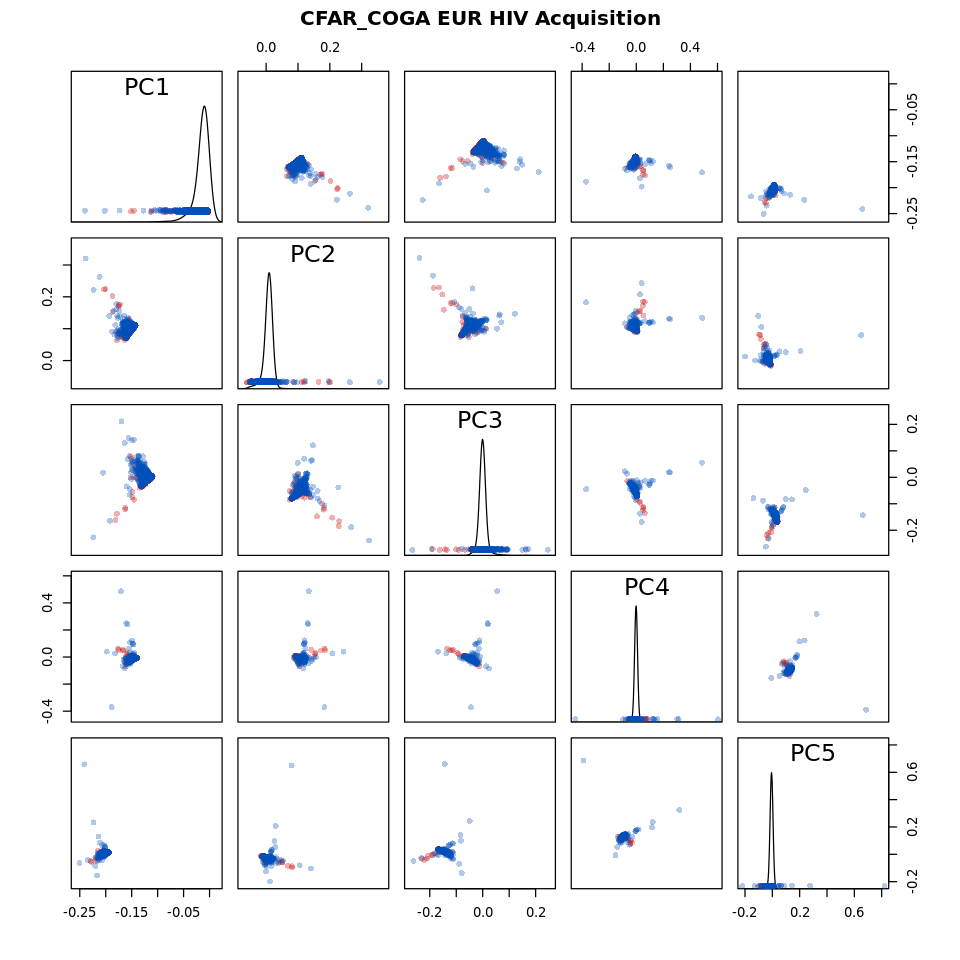

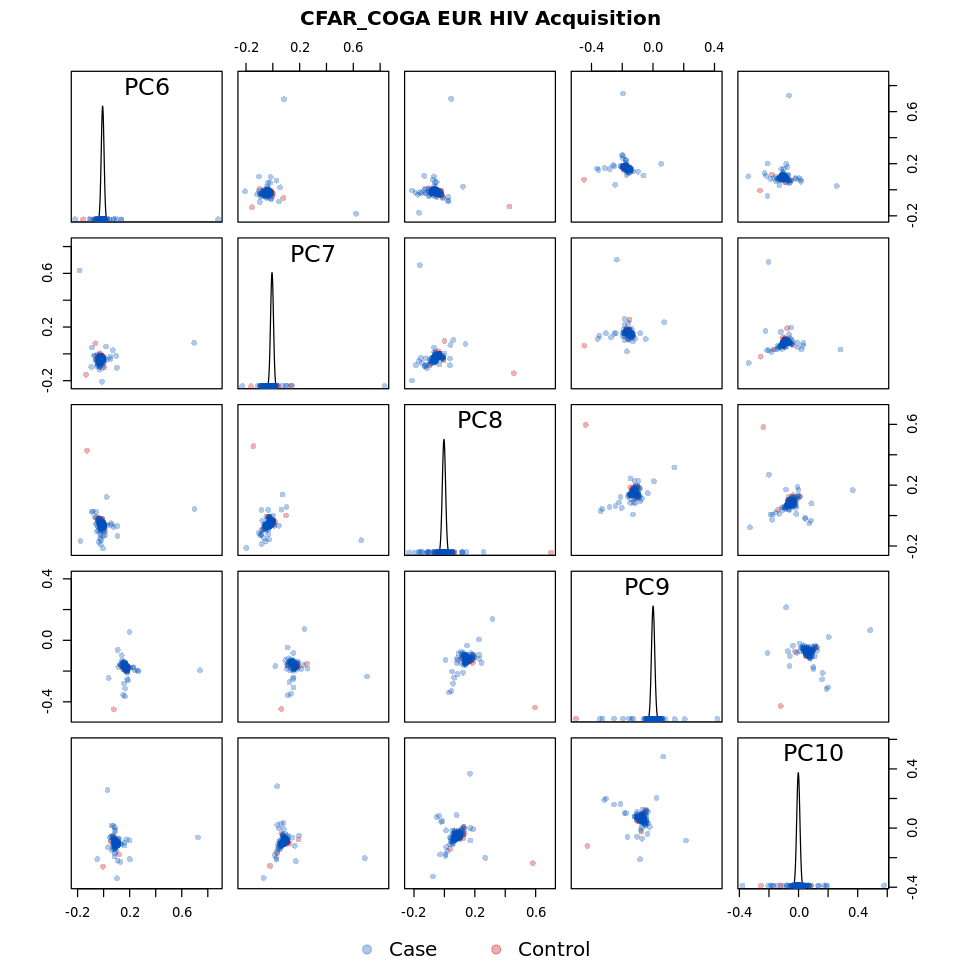

In [3]:
study_title <- "CFAR_COGA EUR HIV Acquisition"
pop <- "eur"
case_control <- TRUE # TRUE or FALSE
case_name <- "Case" # for legend    Note, if not case/control then just edit this one
control_name <- "Control"  # for legend   Note, if not case/control then just leave as is
case_col <- rgb(0,80,190,80, maxColorValue=255) #blue   Note, if not case/control then just edit this one
control_col <- rgb(200,0,0,80, maxColorValue=255) #red  Note, if not case/control then just leave as is

# EUR
plot.pca(case_control = case_control,
        case_col = case_col,
        control_col = control_col,
        df_evec = eur_evec)

### PC Selection

In [4]:
### PC Selection ###
## R functions, DO NOT ALTER THIS CODE ##
create.pedfile <- function(phen_file, pca_file, phenotype, sex_var, covariates, study, ancestry, final_name){
    
    # INPUT:
    # phen_file - phenotype file input of the format "fid iid fatid matid sex age-cov other-cov phentype-name"
    
    # phenotype file
    pheno_data <- read.delim(phen_file, sep="")
    pca_data <- read.delim(pca_file, sep="")
    other_pedcols <- c("fid", "iid", "patid", "matid", sex_var)
    ped_width <- length(other_pedcols) + length(phenotype)
    ped_length <- nrow(pheno_data)
    ped_file <- data.frame(matrix(ncol=ped_width, nrow=ped_length))
    colnames(ped_file) <- c(other_pedcols, phenotype)
    ped_file[phenotype] <- pheno_data[phenotype]
    ped_file[sex_var] <- pheno_data[sex_var]
    ped_file["fid"] <- pheno_data[1]
    ped_file["iid"] <- pheno_data[2]
    
    # master phenotype file & separate covariate file
    nphen_cols <- 15 + length(covariates)
    ncov_cols <- 14 + length(covariates)
    master_phen <- data.frame(matrix(ncol=nphen_cols, nrow=ped_length))
    covar_data <- data.frame(matrix(ncol=ncov_cols, nrow=ped_length))
    colnames(master_phen) <- c("fid", "iid", "patid", "matid", covariates, phenotype,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    colnames(covar_data) <- c("fid", "iid", "patid", "matid", covariates,
                             "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
    
    master_phen[,1:4] <- ped_file[, 1:4]
    covar_data[,1:4] <- ped_file[, 1:4]
    for (i in covariates){
        master_phen[,i] <- pheno_data[,i]
        covar_data[,i] <- pheno_data[,i]
    }
    master_phen[,phenotype] <- ped_file[phenotype]
    
    master_phen[, (nphen_cols-9):nphen_cols] <- pca_data[,3:12]
    covar_data[, (ncov_cols-9):ncov_cols] <- pca_data[,3:12]
    
    dir.create("../final/")
    write.table(master_phen, paste("../final/", final_name, sep=""), sep = "\t", row.names = F, quote=F)
    write.table(ped_file, paste(study,"_", ancestry, "_phen.ped", sep=""), sep = "\t", row.names = F, quote=F)
    write.table(covar_data, paste(study,"_", ancestry, "_cov.ped", sep=""), sep = "\t", row.names = F, quote=F)
} # end function

regression.analysis <- function(cov_file, phen_file, phenotype_name, model_type, ancestry, coded_01){
    options(stringsAsFactors=F)
    
    ancestry <- toupper(ancestry) # for graph titles
    cov_data <- read.delim(cov_file, sep="")
    phen_data <- read.delim(phen_file, sep="")
    pc_names <- paste0("PC", 1:10)
    merge_data <- merge(x=phen_data[,c("iid", phenotype_name)], y=cov_data[, c("iid", pc_names)], by="iid")
    
    model.str <- paste0(phenotype_name, "~", paste(pc_names, collapse=" + ")) 
    cat("MODEL FORMULA:\n\n", model.str, "\n")
    
    # Get model fits
    if (model_type=="continuous"){
        model_fit <- lm(formula=as.formula(model.str), data=merge_data)
        pve_calc <- "Mean Sq"
    }
    else if (model_type=="logistic"){
        if (!coded_01) {
            merge_data[,phenotype_name] <- merge_data[,phenotype_name] - 1
        }
        model_fit <- glm(formula=as.formula(model.str), data=merge_data, family=binomial(link="logit"))
        pve_calc <- "Deviance"
    }
    # Get sequential (type I) sum of squares
    anova_model <- anova(model_fit)
    
    # Calculate percent variance explained and sort
    variance_explained <- cbind(anova_model[pc_names,], 
                    PVE=round(anova_model[pc_names, pve_calc]/sum(anova_model[pc_names, pve_calc])*100, digits=2))
    pve_sorted <- variance_explained[order(variance_explained$PVE, decreasing=T),]
    
    # Output regression info
    cat(paste("\n\n================", ancestry,  "group ================\n"))
    summary(model_fit)
    pve_sorted
    
    # Percent Variance Explained Visualization
    options(repr.plot.width=13, repr.plot.height=5)

    # Set graphical parameters
    cex.factor <- 0.9
    barplot_ylim <- c(0, max(variance_explained$PVE)*1.2)

    pv_list <- vector(length = 10)
    total <- 0
    for (i in 1:nrow(pve_sorted)){
        pv_list[i] <- row.names(pve_sorted[i,])
        total <- total + pve_sorted[i, "PVE"]
        #print(total)
        if (total >= 75) break
    }

    topPCs <- pv_list[which(pv_list != "FALSE")]
    cat("Top PCs: ",topPCs, "\n")
    cat(paste("PVE:     ", total))

    # Visualize PVE
    par(mfrow=c(1,2))
    barplot(height=variance_explained$PVE, names.arg=rownames(variance_explained), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, 
            main=paste(ancestry,"Percent Variance Explained"), ylab="PVE")
    plot(cumsum(variance_explained$PVE), type="b", main=paste(ancestry, "PVE Cumulative Sum"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(variance_explained), cex.axis=cex.factor)

    par(mfrow=c(1,2))
    barplot(height=pve_sorted$PVE, names.arg=rownames(pve_sorted), beside=T, cex.names=cex.factor, 
            col="red3", border="red3", ylim=barplot_ylim, main=paste(ancestry,"Percent Variance Explained (Sorted PCs)"), ylab="PVE")
    plot(cumsum(pve_sorted$PVE), type="b", main=paste(ancestry,"PVE Cumulative Sum (Sorted PCs)"), ylab="PVE", 
         lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
    axis(side=1, at=c(1:10), labels=rownames(pve_sorted), cex.axis=cex.factor)
}

MODEL FORMULA:

 hiv_status~PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



================ EUR group ================
Top PCs:  PC3 PC1 PC2 PC9 
PVE:      89.38

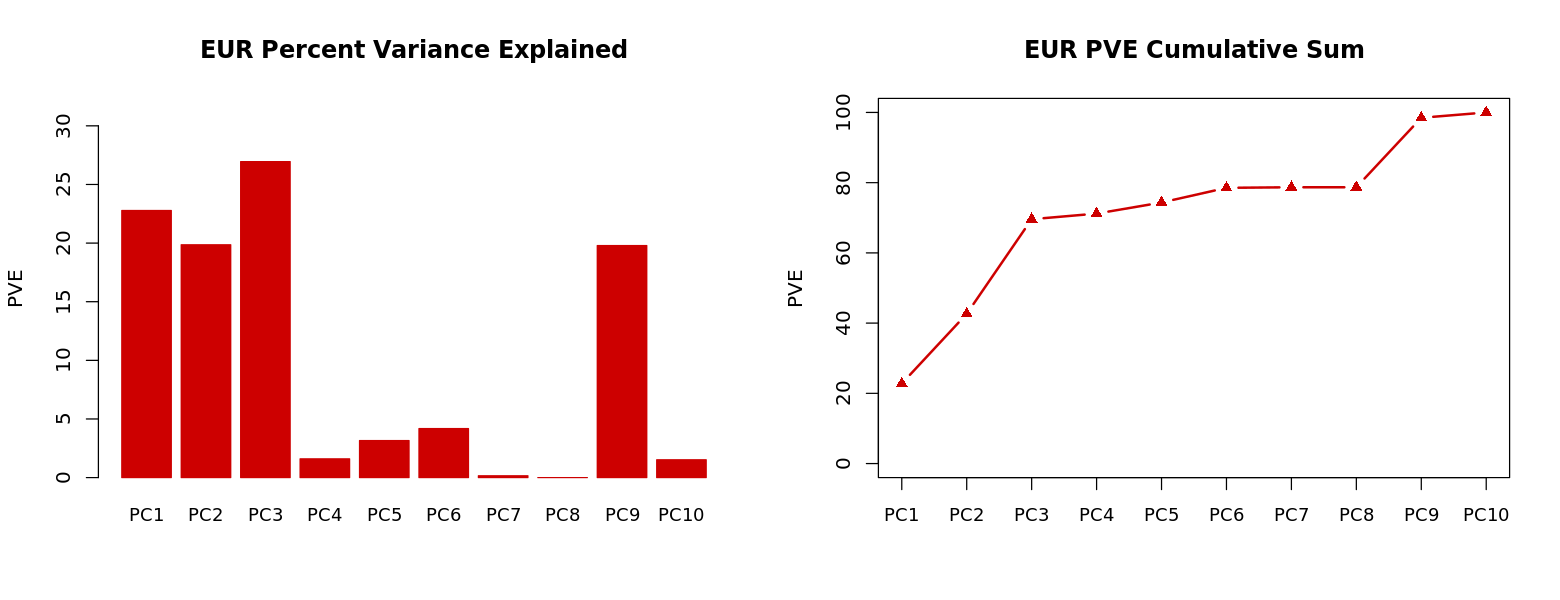

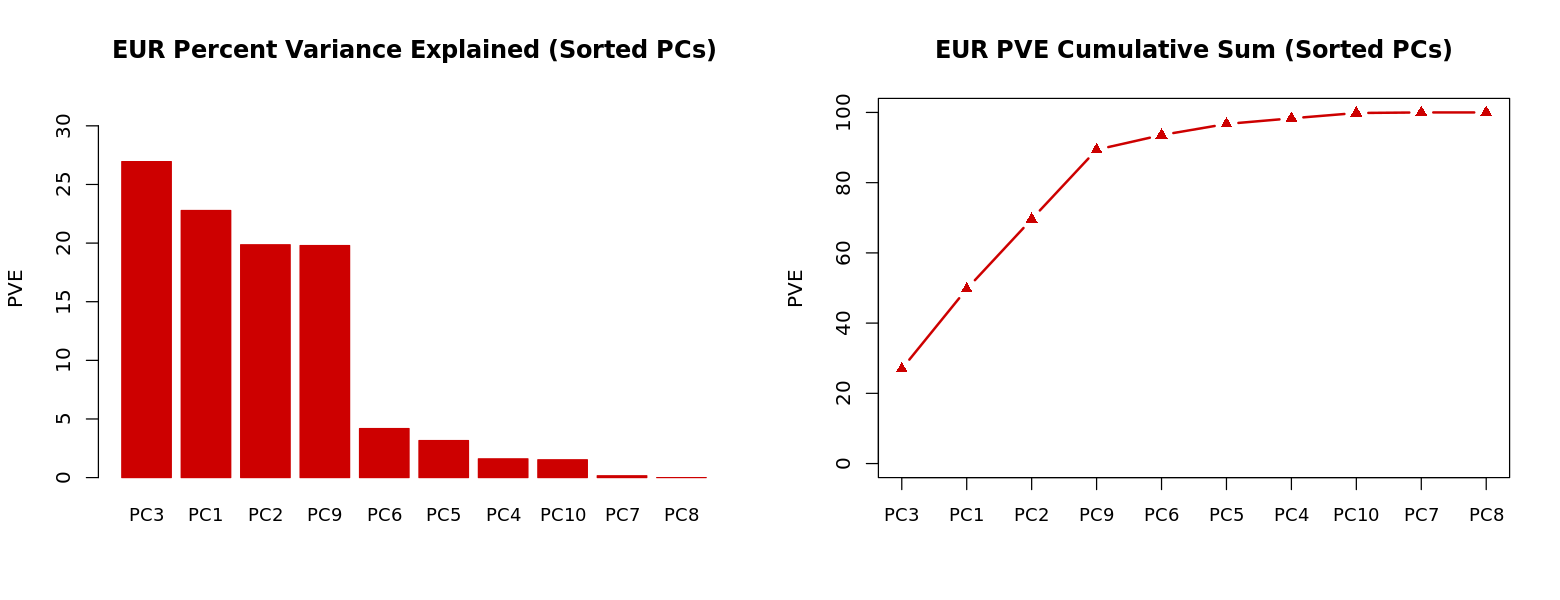

In [5]:
## EUR

study <- "cfar_coga_hiv_acquisition" # for file naming
ancestry <- "eur" # eur, afr, or amr

## variable information from phenotype file ($study_$an_phenotype_table.txt)
phenotype <- "hiv_status" 
sex_var <-  "sex" 
covs <- c(sex_var, "age", "alcohol") # add other covariates

phen_file <- "cfar_coga_phenotype_table_age_sex_alcohol_hiv_status.tsv"
final_name <- "cfar_coga_phenotype_table_age_sex_alcohol_pcs_hiv_status.tsv"  # output phenotype file with merged pcs (separate ped files are created too)
pca_file <- "eur_ld_pruned_top10_eigenvecs.txt"

model_type <- "logistic" # continuous or logistic (if log then must be coded 0 or 1)
coded_01 <- FALSE  # TRUE or FALSE. Are case/controls coded as 0's and 1's? (FALSE if coded as 1's and 2's)
####################################################################################################
####################################################################################################

cov2 <- paste(study, ancestry, "cov.ped", sep="_")
phen2 <- paste(study, ancestry, "phen.ped", sep="_")

create.pedfile(phen_file=phen_file, pca_file=pca_file, phenotype=phenotype,
               sex_var=sex_var, covariates=covs, study=study, ancestry=ancestry, 
               final_name=final_name)
regression.analysis(cov_file=cov2, phen_file=phen2,
                    phenotype_name=phenotype, model_type=model_type,
                    ancestry=ancestry,
                    coded_01)


### Alter iid to match imputed data
The IDs in the genotype (imputed data) are of the form `fid_iid`. Therefore, I need to map the iid in the PED files to this format.


In [1]:
### Bash ##
#cd /Users/jmarks/projects/hiv/gwas/uhs1234/data/acquisition/0010/phenotype/final
#
### AFR
#awk 'NR==1 {print $0} NR>=2{a = $1"_"$2;
#    b = $1"_"$2;
#    $1 = a;
#    $2 = b;
#    print $0 }' OFS="\t" cfar_coga_phenotype_table_age_sex_alcohol_pcs_hiv_status.tsv > \
#    tmp && mv tmp cfar_coga_phenotype_table_age_sex_alcohol_pcs_hiv_status.tsv
#
#
## upload to S3
#aws s3 cp cfar_coga_phenotype_table_age_sex_alcohol_pcs_hiv_status.tsv \
#    s3://rti-hiv/gwas/cfar_coga/data/acquisition/0003/phenotype/

## Sandbox

### Create ProbABEL phenotype file

In [1]:
### Convert your phenotype PED files (as is required for rvtests) to the ProbABEL format ###
## R function, DO NOT ALTER THIS CODE ##
probabel_phenotype <- function(cov_file, pheno_file, study, pop, pcs, other_covs, pheno){
    
    pc_paste <- paste(pcs, collapse="_")
    othercov_paste <- paste(other_covs, collapse="_")
    out_name <- paste(study, pop, pheno, othercov_paste, pc_paste, sep="_")
    out_name <- paste0(out_name, ".txt")

    all_covs <- c(other_covs, pcs)

    # read in data files
    my_cov <- read.table(cov_file, header=T)
    my_pheno <- read.table(pheno_file, header=T)

    num.subjects <- length(my_cov[,1])

    # create new phenotype file (dataframe)
    num_cols = 2 + length(other_covs) # iid + pheno + covs
    covar.data <- data.frame(matrix(ncol = num_cols, nrow = num.subjects))
    names(covar.data) <- c("iid", pheno, other_covs)
    covar.data[1] <- paste(my_pheno$fid, my_pheno$iid, sep = "_")
    covar.data[2] <- my_pheno[, pheno]

    for (cov in all_covs){
        covar.data[, cov] <- my_cov[,cov]
    }

    write.table(x = covar.data, file = out_name, quote = F, row.names = F)
    write.table(x = covar.data[,1], file = paste0("phenotype_ids_", pop), 
                quote = F, row.names = F, col.names=F)
}

In [3]:
### EA
cov_file   <- "CFAR_COGA_EUR_cov.ped"  # name of the input file
pheno_file <- "CFAR_COGA_EUR_phen.ped" # name of the input file
study <- "cfar_coga" # lowercase
pop <- "ea" # ea or aa
#pcs = c("PC1", "PC3", "PC7")
pcs = c("PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10")
other_covs <- c("age", "sex", "alcohol") # field names in header of cov file
pheno <- "hiv" # field names in header of phen file
probabel_phenotype(cov_file, pheno_file, study, pop, pcs, other_covs, pheno)

# Analysis workflow

In [ ]:
# edit variables
project="rti-hiv"
phen=acquisition
study=cfar_coga
ancestry=eur
version=0001

## Cloning this repo and biocloud_wdl_tools submodule together
cd /shared/
git clone --recurse-submodules https://github.com/RTIInternational/biocloud_gwas_workflows.git

# pull for any updates
cd /shared/biocloud_gwas_workflows
git pull
git submodule update --init --recursive


In [ ]:
# Create wf config file for afr, amr, and eur
mkdir -p /shared/bioinformatics/methods/${project}/gwas/${study}/results/${phen}/${version}/
cd /shared/bioinformatics/methods/${project}/gwas/${study}/results/${phen}/${version}/

cp /shared/biocloud_gwas_workflows/association_testing/rvtests/tests/test_rvtests_gwas_wf.json \
    /shared/bioinformatics/methods/rti-hiv/gwas/${study}/results/${phen}/0001/${ancestry}_assoc_wf.json

# Modify config settings manually with vim

# save commit 
mkdir -p /shared/${project}/gwas/${study}/results/${phen}/${version}/${ancestry}/
cd /shared/biocloud_gwas_workflows/
git rev-parse HEAD > /shared/${project}/gwas/${study}/results/${phen}/${version}/${ancestry}/git_hash.txt  
cd /shared/

# Zip biocloud_gwas_workflows repo
zip \
    --exclude=*/var/* \
    --exclude=*.git/* \
    --exclude=*/test/* \
    --exclude=*/.idea/* \
    -r /shared/${project}/gwas/${study}/results/${phen}/${version}/${ancestry}/biocloud_gwas_workflows.zip \
    biocloud_gwas_workflows/

cd /shared/${project}/gwas/${study}/results/${phen}/${version}/${ancestry}/

# note to opens the listening port to the large cromwell server in another window
# ssh -i ~/.ssh/gwas_rsa -L localhost:8000:localhost:8000 ec2-user@18.212.159.244

curl -X POST "http://localhost:8000/api/workflows/v1" -H "accept: application/json" \
    -F "workflowSource=@/shared/biocloud_gwas_workflows/association_testing/rvtests/rvtests_gwas_wf.wdl" \
    -F "workflowInputs=@/shared/bioinformatics/methods/${project}/gwas/${study}/results/${phen}/${version}/${ancestry}_assoc_wf.json" \
    -F "workflowDependencies=@/shared/${project}/gwas/${study}/results/${phen}/${version}/${ancestry}/biocloud_gwas_workflows.zip"
#oldGRCh37 EUR Job ID: {"id":"9a524ec2-02da-4d43-8716-1f550743a7ae","status":"Submitted"}
# EUR Job ID: {"id":"4d58e3db-0a87-4cc2-b9d2-4450d471a31e","status":"Submitted"}

# LDSC
See [this GitHub comment](https://github.com/RTIInternational/bioinformatics/issues/133#issuecomment-989217743).

Look at the LDSC intercept to determine if the inflated lambda value in the QQ plot is due to polygenecity or underlying population structure. 


https://github.com/RTIInternational/biocloud_docker_tools/tree/master/ldsc/v1.0.1
s3://rti-hiv/gwas/cfar_coga/results/acquisition/0003/eur/MetaScore_rsq_gt_0.8_sample_maf_gt_0.01.tsv.gz

## Liftover
We will have to convert or liftover our results from GRCh38 to GRCh37.

In [ ]:
mkdir ~/bin/liftover
cd ~/bin/liftover

rsync -avzP rsync://hgdownload.cse.ucsc.edu/goldenPath/hg38/liftOver/hg38ToHg19.over.chain.gz .
gunzip hg38ToHg19.over.chain.gz

## create hg38 bed files
# create directory structure
mkdir -p ~/rti-hiv/cfar_coga/hg19_liftover/bedfiles/{hg19,hg38,map_file}
cd ~/rti-hiv/cfar_coga
####################################################################################################

# Download hg38 GWAS results
aws s3 cp s3://rti-hiv/gwas/cfar_coga/results/acquisition/0003/eur/MetaScore_rsq_gt_0.8_sample_maf_gt_0.01.tsv.gz .

cd ~/rti-hiv/cfar_coga/hg19_liftover/bedfiles/hg38

# create hg38 BED files
python - <<EOF

import gzip

indir = "/home/ec2-user/rti-hiv/cfar_coga"
outdir = "/home/ec2-user/rti-hiv/cfar_coga/hg19_liftover/bedfiles/hg38"
infile = "{}/MetaScore_rsq_gt_0.8_sample_maf_gt_0.01.tsv.gz".format(indir)
outfile = "{}/cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg38.bed".format(outdir)

with gzip.open(infile, 'rt') as inF, open(outfile, 'w') as outF:
    head = inF.readline()
    line = inF.readline()

    while line:
        sl = line.split()
        chrom = "chr{}".format(sl[1])
        pos = sl[2]
        pos_plus = str(int(pos) + 1)
        outline = "{}\t{}\t{}\n".format(chrom, pos, pos_plus)
        outF.write(outline)
        line = inF.readline()
EOF

# create hg19 BED files
cd ~/rti-hiv/cfar_coga/hg19_liftover/bedfiles

#for chr in {1..22}; do 
    # usage:   ./liftOver oldFile map.chain newFile unMapped
    ~/bin/liftover/liftOver \
        hg38/cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg38.bed  ~/bin/liftover/hg38ToHg19.over.chain \
        hg19/cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg19.bed  hg38/cfar_coga_hg38_to_hg19_unmapped.bed 
#done


## create mapping file
cd /home/ec2-user/rti-hiv/cfar_coga/hg19_liftover/bedfiles/map_file

python - <<EOF
#for chromosome in range(1, 23):
dir = "/home/ec2-user/rti-hiv/cfar_coga/hg19_liftover/bedfiles"
hg19_infile = "{}/hg19/cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg19.bed".format(dir)
hg38_infile = "{}/hg38/cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg38.bed".format(dir)
hg38_unmapped = "{}/hg38/cfar_coga_hg38_to_hg19_unmapped.bed".format(dir)

mapfile = "{}/map_file/cfar_coga_hg38_to_hg19_map.txt".format(dir)
with open(hg19_infile) as HG19, open(hg38_unmapped) as unMAPPED, open(hg38_infile) as HG38, open(mapfile, 'w') as outF:

    line = unMAPPED.readline()

    # add the hg38 positions that didn't liftover to a set
    unmapped_set = set()
    while line:
        if line[0] != "#":
            sl = line.split()
            unmapped_set.add(sl[1]) # add the position

        line = unMAPPED.readline()

    head = "hg38_position\thg19_liftover\n"
    outF.write(head)

    line = HG38.readline()
    hg19_line = HG19.readline()
    # note, the number of unmapped SNPs plus the hg38-->hg19 mapped SNPs equals number of hg38 SNPs 
    while line: # go through the hg38 bed file
        sl = line.split()
        hg38_pos = sl[1]
        if hg38_pos in unmapped_set: # if this hg38 SNP didn't map into hg19, then just keep the hg38 pos
            outline = "{}\t{}\n".format(hg38_pos,hg38_pos)
            outF.write(outline)
        else: # if this hg38 SNP did map into hg19, then write the map
            sl = hg19_line.split()
            hg19_pos = sl[1]
            outline = "{}\t{}\n".format(hg38_pos, hg19_pos)
            outF.write(outline)
            hg19_line = HG19.readline()

        line = HG38.readline()
EOF


## apply liftover
cd /shared/rti-hiv/snp_lookup/mclaren_results/hg38_liftover/

python - <<EOF

import gzip

#for chromosome in range(1, 23):

dir = "/home/ec2-user/rti-hiv/cfar_coga/hg19_liftover/bedfiles"
infile = "/home/ec2-user/rti-hiv/cfar_coga/MetaScore_rsq_gt_0.8_sample_maf_gt_0.01.tsv.gz"
mapfile = "{}/map_file/cfar_coga_hg38_to_hg19_map.txt".format(dir)
outfile = "{}/cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg19.tsv".format(dir)

with gzip.open(infile, 'rt') as inF, open(mapfile) as mapF, open(outfile, 'w') as outF:
    head = inF.readline()
    head = head.split()
    head[2] += "_HG19"
    head = "\t".join(head) + "\n"
    outF.write(head)

    line = inF.readline()
    mapline = mapF.readline() # skip head
    mapline = mapF.readline()
    while line:
        sl = line.split()
        mapsplit = mapline.split()
        sl[2] = mapsplit[1]
        outline = "\t".join(sl) + "\n"
        line = inF.readline()
        mapline = mapF.readline()
        outF.write(outline)
EOF


## ldsc intercept

In [ ]:
procD=/home/ec2-user/rti-hiv/cfar_coga/hg19_liftover/bedfiles
mkdir -p $procD
cd $procD

# Download data
wget https://data.broadinstitute.org/alkesgroup/LDSCORE/eur_w_ld_chr.tar.bz2
wget https://data.broadinstitute.org/alkesgroup/LDSCORE/w_hm3.snplist.bz2
tar -jxvf eur_w_ld_chr.tar.bz2
bunzip2 w_hm3.snplist.bz2

# start interactive session
docker run -it  \
    -v $procD:/data/ \
    rtibiocloud/ldsc:v1.0.1_31bd7c2 /bin/bash

awk '{split($1, a, ":")
     $1=a[1]
     {print $0}}' cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg19.tsv >\
    cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg19_formatted.txt

cd /shared/rti-hiv/gwas_meta/results/eur/033/001/ldsc/
/opt/ldsc/munge_sumstats.py \
    --sumstats cfar_coga_rsq_gt_0.8_sample_maf_gt_0.01_hg19_formatted.txt \
    --signed-sumstats "ALT_EFFECT,0" \
    --a1 "ALT" \
    --a2 "REF" \
    --snp "VARIANT_ID" \
    --out cfar_coga \
    --merge-alleles w_hm3.snplist

/opt/ldsc/ldsc.py \
    --h2 cfar_coga.sumstats.gz \
    --ref-ld-chr eur_w_ld_chr/ \
    --w-ld-chr eur_w_ld_chr/ \
    --out cfar_coga_h2


```
After merging with reference panel LD, 1147849 SNPs remain.
After merging with regression SNP LD, 1147849 SNPs remain.
Using two-step estimator with cutoff at 30.
Total Observed scale h2: 0.181 (0.1271)
Lambda GC: 1.0957
Mean Chi^2: 1.0994
Intercept: 1.0841 (0.0074)
Ratio: 0.8454 (0.074)
```